In [153]:
!pip install pandas matplotlib scikit-learn numpy plotly optuna

In [154]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler
)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import optuna

### 2. Описание данных
Dataset: [NASA | Nearest Earth Objects (1910-2024)](https://www.kaggle.com/datasets/ivansher/nasa-nearest-earth-objects-1910-2024)

В космосе много опасных тел, одно из них - N.E.O. - "Ближайшие земные объекты". Некоторые такие тела действительно представляют опасность для планеты Земля, NASA классифицирует их как "is_hazardous". Этот набор данных содержит ВСЕ наблюдения NASA за подобными объектами с 1910 по 2024 год.

+ **neo_id**: уникальный идентификатор для каждого астероида.
+ **name**: название астероида.
+ **absolute_magnitude**: описывает внутреннюю светимость.
+ **estimated_diameter_min**: минимальный расчетный диаметр в километрах.
+ **estimated_diameter_max**: максимальный расчетный диаметр в километрах.
+ **orbiting_body**: планета, вокруг которой вращается астероид.
+ **relative_velocity**: скорость относительно планеты в км/ч.
+ **miss_distance**: пропущенное расстояние в километрах.
+ **is_hazardous**: логическая переменная, которая показывает, является ли астероид опасным или нет.

# Задание 1. Предварительная подготовка данных

In [159]:
# Загрузка данных
data = pd.read_csv('data/nearest_earth_objects.csv')

In [160]:
data.head(20)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
5,3656926,(2014 BT8),25.00,0.026580,0.059435,Earth,47477.649832,4.290521e+07,False
6,3421513,(2008 OX1),21.50,0.133216,0.297879,Earth,57853.295346,2.727908e+07,True
7,3541504,(2010 OF101),19.75,0.298233,0.666868,Earth,46972.486794,6.997593e+07,False
8,3836942,(2018 YH),21.70,0.121494,0.271669,Earth,37424.548382,5.657727e+06,True
9,3892166,(2019 UP13),23.45,0.054269,0.121350,Earth,38524.867869,6.166118e+07,False


In [163]:
data.dtypes

neo_id                      int64
name                       object
absolute_magnitude        float64
estimated_diameter_min    float64
estimated_diameter_max    float64
orbiting_body              object
relative_velocity         float64
miss_distance             float64
is_hazardous                 bool
dtype: object

#### Проверка дубликатов

In [166]:
duplicates = data.duplicated().sum()
print(f'Количество дубликатов: {duplicates}')
if duplicates > 0:
    data.drop_duplicates(inplace=True)
    print('Дубликаты удалены.')

Количество дубликатов: 0


#### Заполнение пропусков

In [169]:
data.fillna({
    'absolute_magnitude': 0,
    'estimated_diameter_min': 0,
    'estimated_diameter_max': 0,
    'relative_velocity': 0,
    'miss_distance': 0,
    'orbiting_body': 'other'
}, inplace=True)

#### Построение графика количества значений по каждому классу

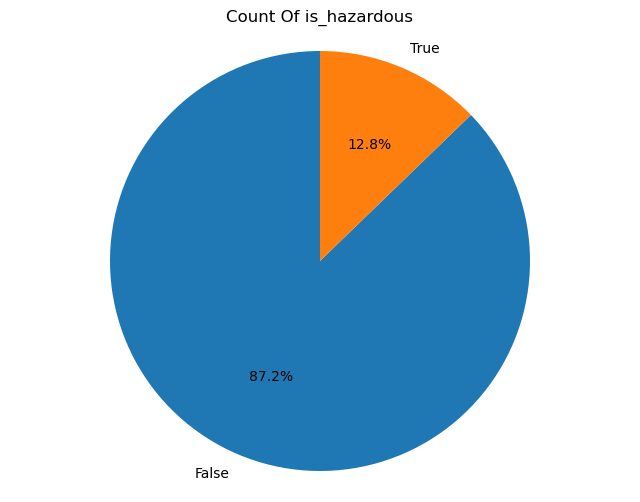

In [172]:
# График количества значений по классу is_hazardous
def is_hazardous_plot(counts):
    plt.figure(figsize=(8, 6))
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=90)
    plt.title('Count Of is_hazardous')
    plt.axis('equal')
    plt.show()

is_hazardous_plot(data['is_hazardous'].value_counts())

Видно, что у нас дисбаланс классов, который нужно исправить

#### Проверка уникальности значений

In [176]:
# посчитать количество уникальных значений
unique_counts = data.select_dtypes("object").nunique()
unique_counts

name             33514
orbiting_body        1
dtype: int64

#### Определение числовых и категориальных признаков. Заполнить пропуски в данных

In [179]:
# удалить идентификатор, так как он не несёт никакой полезной для нас информации
data.drop(columns=['neo_id'], inplace=True)
numerical_cols = data.select_dtypes(include=['float64', 'int']).columns
data[numerical_cols] = data[numerical_cols].fillna(0)
numerical_cols

Index(['absolute_magnitude', 'estimated_diameter_min',
       'estimated_diameter_max', 'relative_velocity', 'miss_distance'],
      dtype='object')

In [181]:
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].fillna('other')
categorical_cols

Index(['name', 'orbiting_body'], dtype='object')

#### Применить стандартизацию к числовым признакам и закодировать категориальные признаки

In [184]:
# Создание экземпляра StandardScaler
scaler = StandardScaler()

# Стандартизация числовых признаков
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data[numerical_cols]

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance
0,-1.298800,0.755596,0.755596,0.783537,0.799476
1,-1.518087,1.186911,1.186911,2.230715,0.686711
2,-0.507314,-0.068436,-0.068436,-0.992271,1.235756
3,-0.788275,0.130831,0.130831,1.054176,-0.536196
4,-0.079021,-0.258515,-0.258515,0.188485,1.038958
...,...,...,...,...,...
338194,1.935672,-0.486459,-0.486459,0.211610,1.084537
338195,1.973362,-0.487264,-0.487264,-1.133742,-0.579886
338196,-0.346618,-0.152801,-0.152801,-1.485978,0.574057
338197,0.327687,-0.361361,-0.361361,0.194617,-1.749816


In [186]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение LabelEncoder к каждому категориальному столбцу
for col in categorical_cols:
    data[col] = label_encoder.fit_transform(data[col])

In [187]:
data.head(20)

,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,30603,-1.298800,0.755596,0.755596,0,0.783537,0.799476,False
1,31395,-1.518087,1.186911,1.186911,0,2.230715,0.686711,True
2,32118,-0.507314,-0.068436,-0.068436,0,-0.992271,1.235756,False
3,736,-0.788275,0.130831,0.130831,0,1.054176,-0.536196,False
4,4880,-0.079021,-0.258515,-0.258515,0,0.188485,1.038958,False
5,7484,0.709039,-0.418061,-0.418061,0,-0.135724,0.065941,False
6,2982,-0.490182,-0.078322,-0.078322,0,0.257304,-0.686257,True
7,4305,-1.089793,0.447419,0.447419,0,-0.154860,1.369050,False
8,15221,-0.421655,-0.115667,-0.115667,0,-0.516535,-1.727048,True
9,16520,0.177955,-0.329843,-0.329843,0,-0.474855,0.968801,False


#### Разделить на тренировочную и обучающую выборки

In [191]:
target_column = "is_hazardous"
features = ['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'miss_distance', 'relative_velocity']
X = data[features]
y = data[target_column]

In [193]:
print(X.shape, y.shape)

(338199, 5) (338199,)


In [195]:
# Избавиться от дисбаланса классов
# SMOTE создает синтетические примеры, основываясь на существующих данных
smt = SMOTE()
X_resampled, y_resampled = smt.fit_resample(X, y)

In [196]:
print(X_resampled.shape, y_resampled.shape)

(590074, 5) (590074,)


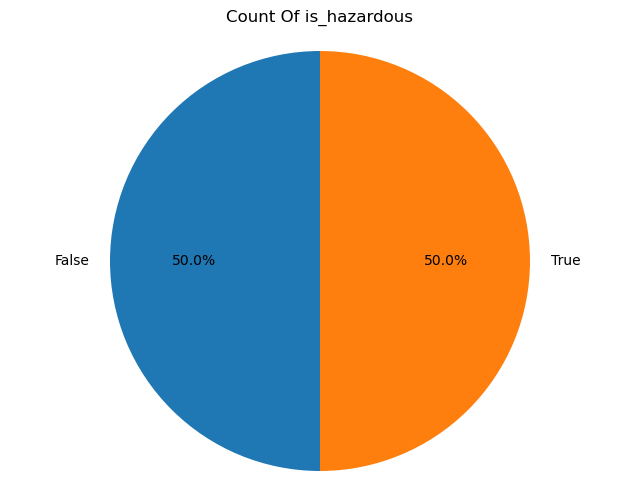

In [199]:
is_hazardous_plot(y_resampled.value_counts())

In [201]:
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.25, stratify=y_resampled, random_state=42
)
X_train.head(2)

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
105024,-0.277749,-0.183739,-0.183739,0.205042,0.704377
300963,-0.507314,-0.068436,-0.068436,-1.621476,-0.362116


In [203]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(442555, 5) (442555,)
(147519, 5) (147519,)


In [205]:
X_train.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
105024,-0.277749,-0.183739,-0.183739,0.205042,0.704377
300963,-0.507314,-0.068436,-0.068436,-1.621476,-0.362116
42570,0.914620,-0.438506,-0.438506,-0.716444,-0.361983
494681,-1.233318,0.650462,0.650462,1.295388,0.099179
486174,-1.422332,0.982867,0.982867,-1.355185,2.086733


In [207]:
X_test.head()

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,miss_distance,relative_velocity
17466,-2.227341,3.880526,3.880526,-0.144813,-1.179890
237894,-0.246912,-0.196691,-0.196691,0.501549,0.233182
358584,-0.649843,0.023387,0.023387,-0.005259,-0.310576
420994,-1.294623,0.748638,0.748638,0.918059,1.134838
73710,-0.634089,0.012245,0.012245,0.042033,-1.257677


# Задание №2. Обучение модели и вычисление метрик

In [210]:
def get_report(report):
    """Функция для вывода метрик"""
    print(f"Accuracy: {report['accuracy']:.2f}")
    print(f"Класс 1 (неопасные): Recall: {report['False']['recall']:.2f}, Precision: {report['False']['precision']:.2f}, F1-Score: {report['False']['f1-score']:.2f}")
    print(f"Класс 2 (опасные): Recall: {report['True']['recall']:.2f}, Precision: {report['True']['precision']:.2f}, F1-Score: {report['True']['f1-score']:.2f}")

In [212]:
def evaluate(_model, X_train, y_train, X_test, y_test):
    """Функция для оценки модели и её производительности"""

    # Предсказания на тренировочной выборке
    y_train_pred = _model.predict(X_train)

    # Предсказания на тестовой выборке
    y_test_pred = _model.predict(X_test)

    # Вычисление метрик для тренировочной выборки
    train_report = classification_report(y_train, y_train_pred, output_dict=True)

    # Вычисление метрик для тестовой выборки
    test_report = classification_report(y_test, y_test_pred, output_dict=True)

    # Вывод метрик
    print("Метрики на тренировочной выборке:")
    get_report(train_report)

    print("\nМетрики на тестовой выборке:")
    get_report(test_report)

    return f1_score(y_test, y_test_pred, average='weighted')

In [214]:
# Создание и обучение модели с k=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [216]:
# Предсказание на тренировочной и тестовой выборке, вычисление метрик
evaluate(knn, X_train, y_train, X_test, y_test)

Метрики на тренировочной выборке:
Accuracy: 0.93
Класс 1 (неопасные): Recall: 0.87, Precision: 0.99, F1-Score: 0.92
Класс 2 (опасные): Recall: 0.99, Precision: 0.88, F1-Score: 0.93

Метрики на тестовой выборке:
Accuracy: 0.90
Класс 1 (неопасные): Recall: 0.83, Precision: 0.98, F1-Score: 0.90
Класс 2 (опасные): Recall: 0.98, Precision: 0.85, F1-Score: 0.91


0.9034355185921449

### Выводы: 
1. Модель демонстрирует высокую точность как на тренировочной, так и на тестовой выборках, что указывает на хорошую обобщающую способность.
2. Класс 1 (неопасные)
    * Recall показывает, что модель хорошо находит большинство объектов класса "неопасные", хотя на тестовой выборке наблюдается небольшое снижение.
    * Precision остается высоким, что означает, что большинство предсказанных объектов действительно относятся к классу "неопасные".
    * F1-Score также высок, что указывает на сбалансированную производительность между Recall и Precision.
3. Класс 2 (опасные)
    * Модель показывает отличные результаты по Recall для класса "опасные", что говорит о том, что она успешно идентифицирует почти все объекты этого класса.
    * Снижение Precision на тестовой выборке может указывать на то, что модель иногда ошибочно классифицирует объекты из класса "неопасные" как "опасные".
    * F1-Score остается высоким, что подтверждает хорошую сбалансированность модели.

Количество соседей (k): 1, Точность модели на тестовых данных: 0.93

Количество соседей (k): 2, Точность модели на тестовых данных: 0.92

Количество соседей (k): 3, Точность модели на тестовых данных: 0.91

Количество соседей (k): 4, Точность модели на тестовых данных: 0.91

Количество соседей (k): 5, Точность модели на тестовых данных: 0.90

Количество соседей (k): 6, Точность модели на тестовых данных: 0.90

Количество соседей (k): 7, Точность модели на тестовых данных: 0.90

Количество соседей (k): 8, Точность модели на тестовых данных: 0.90

Количество соседей (k): 9, Точность модели на тестовых данных: 0.89

Количество соседей (k): 10, Точность модели на тестовых данных: 0.89

Количество соседей (k): 11, Точность модели на тестовых данных: 0.88

Количество соседей (k): 12, Точность модели на тестовых данных: 0.89

Количество соседей (k): 13, Точность модели на тестовых данных: 0.88

Количество соседей (k): 14, Точность модели на тестовых данных: 0.88

Количество соседей (k): 15, Т

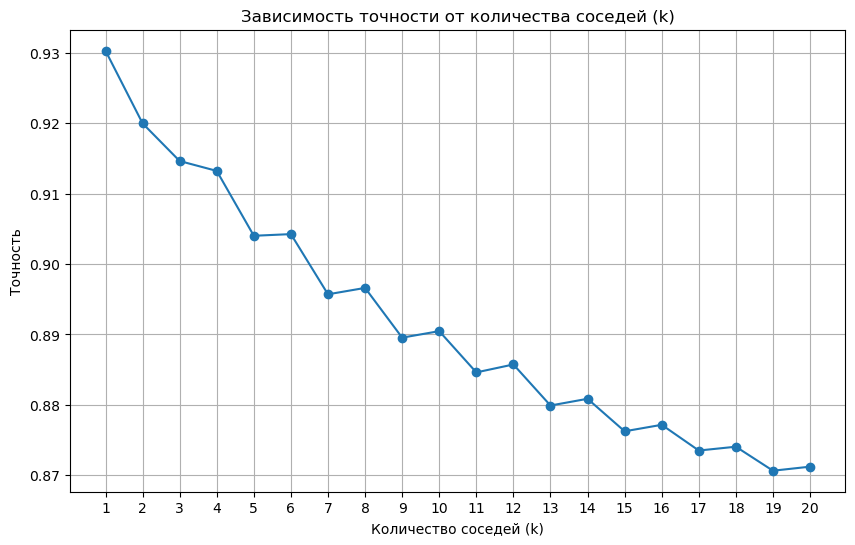

In [219]:
# Список значений k для тестирования
k_values = range(1, 21)
accuracies = []

# Обучение модели и оценка точности для каждого значения k
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acr = accuracy_score(y_test, y_pred)
    accuracies.append(acr)
    print(f'Количество соседей (k): {k}, Точность модели на тестовых данных: {acr:.2f}\n')

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('Зависимость точности от количества соседей (k)')
plt.xlabel('Количество соседей (k)')
plt.ylabel('Точность')
plt.xticks(k_values)
plt.grid()
plt.show()

### Выводы: 
* При использовании 1 соседа (k=1) модель показывает наивысшую точность — 0.93. Это свидетельствует о том, что использование одного ближайшего соседа позволяет модели хорошо классифицировать данные.
* С увеличением количества соседей (k) наблюдается постепенное снижение точности. Например, при k=2 точность составляет 0.92, а при k=3 — 0.91. Это снижение продолжает наблюдаться до k=15, где точность стабилизируется на уровне 0.88.
* Начиная с k=6, точность остается относительно стабильной, колеблясь между 0.87 и 0.90. Это указывает на то, что увеличение числа соседей не всегда приводит к улучшению качества предсказаний.
* На основании полученных данных оптимальным значением для k является 1 или 2, так как они обеспечивают наивысшую точность. Однако использование одного соседа может привести к переобучению модели, особенно если данные имеют шум.
* При увеличении k модель становится менее чувствительной к шуму в данных, что может быть полезно для повышения обобщающей способности, но может также привести к потере информации.

# Задание №3. Настройка гиперпараметров модели

In [233]:
def objective(trial):
    # Подбор гиперпараметров
    n_neighbors = trial.suggest_int('n_neighbors', 1, 15)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'chebyshev'])
    algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'auto'])
    
    # Обучение модели
    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, algorithm=algorithm, n_jobs=-1)
    model.fit(X_train, y_train)

    # Вычисление метрик
    return evaluate(model, X_train, y_train, X_test, y_test)

In [235]:
# Создание и оптимизация исследования Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5, n_jobs=-1)

# Получение лучших параметров
best_params = study.best_params
print("Лучшие параметры:", best_params)

[I 2024-12-08 13:27:55,588] A new study created in memory with name: no-name-dfbbfc6c-956f-4d1a-90a6-86af06dc7914
[I 2024-12-08 13:30:32,297] Trial 3 finished with value: 0.898743133364598 and parameters: {'n_neighbors': 7, 'metric': 'manhattan', 'algorithm': 'auto'}. Best is trial 3 with value: 0.898743133364598.


Метрики на тренировочной выборке:
Accuracy: 0.92
Класс 1 (неопасные): Recall: 0.85, Precision: 0.99, F1-Score: 0.91
Класс 2 (опасные): Recall: 0.99, Precision: 0.87, F1-Score: 0.92

Метрики на тестовой выборке:
Accuracy: 0.90
Класс 1 (неопасные): Recall: 0.82, Precision: 0.97, F1-Score: 0.89
Класс 2 (опасные): Recall: 0.98, Precision: 0.84, F1-Score: 0.91


[I 2024-12-08 13:30:32,768] Trial 1 finished with value: 0.9133608759893 and parameters: {'n_neighbors': 2, 'metric': 'chebyshev', 'algorithm': 'kd_tree'}. Best is trial 1 with value: 0.9133608759893.


Метрики на тренировочной выборке:
Accuracy: 0.98
Класс 1 (неопасные): Recall: 1.00, Precision: 0.97, F1-Score: 0.98
Класс 2 (опасные): Recall: 0.97, Precision: 1.00, F1-Score: 0.98

Метрики на тестовой выборке:
Accuracy: 0.91
Класс 1 (неопасные): Recall: 0.90, Precision: 0.92, F1-Score: 0.91
Класс 2 (опасные): Recall: 0.92, Precision: 0.91, F1-Score: 0.91


[I 2024-12-08 13:30:44,836] Trial 2 finished with value: 0.8734170608706071 and parameters: {'n_neighbors': 13, 'metric': 'chebyshev', 'algorithm': 'auto'}. Best is trial 1 with value: 0.9133608759893.


Метрики на тренировочной выборке:
Accuracy: 0.89
Класс 1 (неопасные): Recall: 0.80, Precision: 0.98, F1-Score: 0.88
Класс 2 (опасные): Recall: 0.98, Precision: 0.83, F1-Score: 0.90

Метрики на тестовой выборке:
Accuracy: 0.87
Класс 1 (неопасные): Recall: 0.78, Precision: 0.97, F1-Score: 0.86
Класс 2 (опасные): Recall: 0.97, Precision: 0.81, F1-Score: 0.89


[I 2024-12-08 13:30:50,177] Trial 0 finished with value: 0.916231865788924 and parameters: {'n_neighbors': 4, 'metric': 'manhattan', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.916231865788924.


Метрики на тренировочной выборке:
Accuracy: 0.95
Класс 1 (неопасные): Recall: 0.93, Precision: 0.98, F1-Score: 0.95
Класс 2 (опасные): Recall: 0.98, Precision: 0.93, F1-Score: 0.96

Метрики на тестовой выборке:
Accuracy: 0.92
Класс 1 (неопасные): Recall: 0.88, Precision: 0.95, F1-Score: 0.91
Класс 2 (опасные): Recall: 0.96, Precision: 0.89, F1-Score: 0.92


[I 2024-12-08 13:31:06,695] Trial 4 finished with value: 0.8849641346516465 and parameters: {'n_neighbors': 12, 'metric': 'euclidean', 'algorithm': 'ball_tree'}. Best is trial 0 with value: 0.916231865788924.


Метрики на тренировочной выборке:
Accuracy: 0.90
Класс 1 (неопасные): Recall: 0.83, Precision: 0.97, F1-Score: 0.89
Класс 2 (опасные): Recall: 0.98, Precision: 0.85, F1-Score: 0.91

Метрики на тестовой выборке:
Accuracy: 0.89
Класс 1 (неопасные): Recall: 0.80, Precision: 0.96, F1-Score: 0.88
Класс 2 (опасные): Recall: 0.97, Precision: 0.83, F1-Score: 0.89
Лучшие параметры: {'n_neighbors': 4, 'metric': 'manhattan', 'algorithm': 'ball_tree'}


### Выводы:
1. Trials:
    * Trial 1: Лучшая точность на тестовой выборке составила 0.91 с параметрами n_neighbors=2, metric='chebyshev', algorithm='kd_tree'.
    * Trial 2: Значение метрики составило только 0.8734, что значительно ниже.
    * Trial 3: Точность на тестовой выборке составила 0.90 с параметрами n_neighbors=7, metric='manhattan', algorithm='auto'.
    * Trial 4: Значение метрики составило 0.8849, также ниже по сравнению с лучшим результатом.
2. Модель с параметрами n_neighbors=4, metric='manhattan' и algorithm='ball_tree' показала наилучшие результаты как на тренировочной, так и на тестовой выборках.
3. Высокие значения recall и precision для обоих классов указывают на хорошую способность модели различать опасные и неопасные объекты.

In [236]:
# Обучение модели с лучшими метриками
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', metric='manhattan', n_neighbors=4)

In [237]:
# Предсказание на тренировочной и тестовой выборке, вычисление метрик
evaluate(best_model, X_train, y_train, X_test, y_test)

Метрики на тренировочной выборке:
Accuracy: 0.95
Класс 1 (неопасные): Recall: 0.93, Precision: 0.98, F1-Score: 0.95
Класс 2 (опасные): Recall: 0.98, Precision: 0.93, F1-Score: 0.96

Метрики на тестовой выборке:
Accuracy: 0.92
Класс 1 (неопасные): Recall: 0.88, Precision: 0.95, F1-Score: 0.91
Класс 2 (опасные): Recall: 0.96, Precision: 0.89, F1-Score: 0.92


0.916231865788924

### Выводы:
1. Высокая точность (accuracy) на тренировочной выборке (95%) и хорошая на тестовой выборке (92%) указывают на то, что модель хорошо обобщает данные и не переобучена.
2. Класс 1 (неопасные):
    * На тренировочной выборке модель показывает высокий recall (93%) и precision (98%), что говорит о том, что она успешно идентифицирует большинство неопасных объектов и минимизирует ложные срабатывания.
    * На тестовой выборке recall снижается до 88%, что может указывать на некоторую потерю информации или сложность в распознавании неопасных объектов в новых данных, однако precision остается высоким (95%).
3. Класс 2 (опасные):
    * Модель показывает отличные результаты как по recall (98% на тренировочной и 96% на тестовой выборках), так и по precision (93% на тренировочной и 89% на тестовой). Это свидетельствует о том, что модель надежно распознает опасные объекты.